# Quick Start

このクイックスタートガイドでは、MINTOを使用して最適化数値実験をセットアップ、実行、保存する基本的な手順を説明します。

## インストール
 
```bash
uv add minto
# or
pip install minto
```

## 基本的な使用法

`minto`を使用して、最適化数値実験中に生成される様々なデータを簡単に記録することができます。
このガイドでは、`ommx_pyscipopt_adapter`を使用して、OMMXインスタンスをPySCIPOptソルバーで解き、その結果をMINTOで保存する方法を示します。

まずは必要なモジュールをインポートします。


In [2]:
import minto
import ommx_pyscipopt_adapter as scip_ad
from ommx.dataset import miplib2017

`from ommx.dataset import miplib2017`を使用して、MIPLIB2017からインスタンスをロードします。

In [3]:
instance_name = "reblock115"
instance = miplib2017(instance_name)

このインスタンスに対して計算時間を変えながら目的関数値がどう変化するかを調べます。計算時間のリストを作っておきます。

In [31]:
timelimit_list = [0.1, 0.5, 1, 2]

では、早速mintoを使って実験をセットアップしましょう。
まずはExperimentオブジェクトを作成します。

In [32]:
experiment = minto.Experiment(
    "quickstart_example",
    auto_saving=False,     # True is recommended, but set to False for demonstration
    verbose_logging=False  # True is recommended, but set to False for demonstration
)

- `auto_saving=False`に設定すると、各実験の後に自動的に保存されなくなります。デフォルトは`True`です。途中で実験が中断されたときに実験結果が全て消えたとか悲しいことが起きないようにするために、`auto_saving=True`を推奨します。このガイドでは簡単のために`False`に設定しています。
- `verbose_logging=False`に設定すると、詳細なログが表示されなくなります。デフォルトは`True`です。例えば上記をTrueに設定するとExperimentオブジェクト作成時に以下のようなログが表示されます。

```text
[2025-10-21 00:13:54] 🚀 [36mStarting experiment 'quickstart_example'[0m
[2025-10-21 00:13:54]   ├─ 📊 [36mEnvironment: OS: Darwin 24.6.0, CPU: Apple M2 (8 cores), Memory: 24.0 GB, Python: 3.11.11[0m
[2025-10-21 00:13:54]   ├─ 📊 [36mEnvironment Information[0m
[2025-10-21 00:13:54]       ├─ [36mOS: Darwin 24.6.0[0m
[2025-10-21 00:13:54]       ├─ [36mPlatform: macOS-15.6.1-arm64-arm-64bit[0m
[2025-10-21 00:13:54]       ├─ [36mCPU: Apple M2 (8 cores)[0m
[2025-10-21 00:13:54]       ├─ [36mMemory: 24.0 GB[0m
[2025-10-21 00:13:54]       ├─ [36mArchitecture: arm64[0m
[2025-10-21 00:13:54]       ├─ [36mPython: 3.11.11[0m
[2025-10-21 00:13:54]       ├─ [36mVirtual Environment: /.venv[0m
[2025-10-21 00:13:54]       ├─ [36mKey Package Versions:[0m
```

## `run`を使って実験を記録する


ではmintoで実験結果を保存しながら数値実験を実行してみましょう。timelimitを変更しながら最適化計算を行いたい場合は、

```python
for timelimit in timelimit_list:
    # ここに最適化計算のコードを記述
```

のように書きたいと思います。このforループ内をwith句で囲むことで、それぞれの実行を一つの`run`として記録することができます。
とりあえずみてみましょう。

In [33]:
adapter = scip_ad.OMMXPySCIPOptAdapter(instance)
scip_model = adapter.solver_input

for timelimit in timelimit_list:
    with experiment.run() as run:
        run.log_parameter("timelimit", timelimit)

        scip_model.setParam("limits/time", timelimit)
        scip_model.optimize()
        solution = adapter.decode(scip_model)

        run.log_solution(solution)

`verbose_logging=True`に設定すると、各実験の開始と終了時に詳細なログが表示されます。例えば上記をTrueに設定すると以下のようなログが表示されます。

```text
[2025-10-21 00:27:51]   ├─ 🏃 Created run #0
[2025-10-21 00:27:51]       ├─ 📝 Parameter: timelimit = 0.1
[2025-10-21 00:27:51]       ├─ 🎯 Solution '0': objective: 0.000, feasible: True
[2025-10-21 00:27:51]   ├─ ✅ Run #0 completed (0.1s)[0m
[2025-10-21 00:27:51]   ├─ 🏃 Created run #1[0m
[2025-10-21 00:27:51]       ├─ 📝 Parameter: timelimit = 0.5[0m
[2025-10-21 00:27:51]       ├─ 🎯 Solution '0': objective: -28241914.988, feasible: True
[2025-10-21 00:27:51]   ├─ ✅ Run #1 completed (0.4s)[0m
[2025-10-21 00:27:51]   ├─ 🏃 Created run #2[0m
[2025-10-21 00:27:51]       ├─ 📝 Parameter: timelimit = 1
[2025-10-21 00:27:52]       ├─ 🎯 Solution '0': objective: -28241914.988, feasible: True
[2025-10-21 00:27:52]   ├─ ✅ Run #2 completed (0.5s)
[2025-10-21 00:27:52]   ├─ 🏃 Created run #3
[2025-10-21 00:27:52]       ├─ 📝 Parameter: timelimit = 2
[2025-10-21 00:27:53]       ├─ 🎯 Solution '0': objective: -28241914.988, feasible: True
[2025-10-21 00:27:53]   ├─ ✅ Run #3 completed (1.0s)
```



```python
with experiment.run() as run:
    ...
```
のように`with`句で囲んだ部分が一つの`run`として記録されます。

この`with`句の中で、`run`オブジェクトの`.log_*`メソッドを使用して、パラメータや結果を記録します。  
例えば、`log_parameter`メソッドではスカラー値（int, float, str, bool）をパラメータとして記録できます。  
`log_solution`は`ommx.v1.Solution`オブジェクトを記録することができます。

このように`minto`は数理最適化ソルバーの共通フォーマットであるOMMXをサポートすることで、様々なソルバーやインスタンスに対しても同じコードで実験を記録できるようにしています。


## 実験結果の確認


では次に実験結果を確認してみましょう。`experiment.get_run_table()`メソッドを使用すると、実験結果をPandasのDataFrame形式で取得できます。

In [34]:
run_df = experiment.get_run_table()
run_df

metadata        parameter solution_0                                \
       elapsed_time run_id timelimit   feasible name     objective optimality   
run_id                                                                          
0          0.113005      0       0.1       True    0  0.000000e+00          0   
1          0.407464      1       0.5       True    0  0.000000e+00          0   
2          0.507487      2       1.0       True    0 -2.920013e+07          0   
3          1.007539      3       2.0       True    0 -2.920013e+07          0   

                         
       relaxation start  
run_id                   
0               0  None  
1               0  None  
2               0  None  
3               0  None

`.get_run_table`で出力されるdataframeはdouble header形式になっていることに注意してください。またこのdataframeは保存したデータそのものではなく、保存したデータをもとに生成された集計データであることにも注意してください。例えば`log_solution`で`ommx.v1.Solution`オブジェクトを保存した場合、そのままの形でdataframeに保存されるわけではなく、目的関数値や実行時間などの集計情報がdataframeとして出力されます。

また、`'solution_0'`の`_0`は保存した解オブジェクトのインデックスを表しています。複数の解を保存した場合、それぞれ`solution_0`, `solution_1`, ...のように列が追加されます。この`_0`は

``` python
run.log_solutin('solution_name', solution)
```
のようにnameを指定して変更できます。このようにした場合の列名は`solution_solution_name`となります。

では計算時間に対して目的関数値がどうなっているのかをプロットしてみましょう。double header形式のDataFrameでは、`x`や`y`にタプルで列名を指定する必要があることに注意してください。

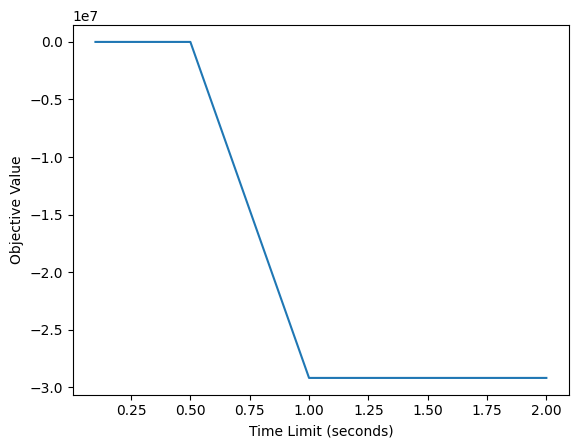

In [36]:
import matplotlib.pyplot as plt

run_df.plot(x=("parameter", "timelimit"), y=("solution_0", "objective"), legend=False, ylabel="Objective Value", xlabel="Time Limit (seconds)")
plt.show()

目的関数値を知りたいとかであれば上記のようにdataframeを取得して確認することができますが、具体的なsolutionオブジェクトを取得したい場合は、`Experiment`オブジェクトの`runs`属性から各`Run`オブジェクトにアクセスし、さらにその`solutions`属性から保存された解オブジェクトにアクセスすることができます。例えば、

In [45]:
print(experiment.runs[0].solutions)

experiment.runs[0].solutions["0"].decision_variables_df

{'0': Solution(raw=<builtins.Solution object at 0x125d707b0>, annotations={})}


,kind,lower,upper,name,subscripts,description,substituted_value,value
id,,,,,,,,
0,Binary,0.0,1.0,X_103_3,[],<NA>,<NA>,0.0
1,Binary,0.0,1.0,X_23_7,[],<NA>,<NA>,0.0
2,Binary,0.0,1.0,X_79_5,[],<NA>,<NA>,0.0
3,Binary,0.0,1.0,X_92_9,[],<NA>,<NA>,0.0
4,Binary,0.0,1.0,X_36_6,[],<NA>,<NA>,0.0
...,...,...,...,...,...,...,...,...
1145,Binary,0.0,1.0,X_73_5,[],<NA>,<NA>,0.0
1146,Binary,0.0,1.0,X_15_2,[],<NA>,<NA>,0.0
1147,Binary,0.0,1.0,X_4_1,[],<NA>,<NA>,0.0


のようにしてアクセスできます。`'0'`は保存したsolutionオブジェクトに自動で付与されたインデックスです。solutionオブジェクトを一つしか保存していない場合は

In [46]:
experiment.runs[0].get_solution()

Solution(raw=<builtins.Solution object at 0x125d707b0>, annotations={})

のように`.get_solution()`という糖衣構文を使ってアクセスすることもできます。このメソッドでは自動で一番最初に追加されたsolutionオブジェクトを返します。

## データの保存と読み込み

`minto`では実験データの保存方法として2つの方法をサポートしています。

| 保存方法 | 特徴 / 使いわけ |
| ---------------------------- | ------------------------ |
| ファイルベース保存 | 各実験データが個別のファイルとして保存され、簡単に管理できます。`auto_saving=True`ではこの方法で保存されます。runごとにファイルが生成されるため途中で実行が中断されてもそれまでの実験データが保存されます。 |
| OMMX Archive保存 | 実験データを一つのOMMX Archiveファイルにまとめて保存します。一つのファイル (OCI Artifact) として保存されるため、他の人に共有するのに便利です。GitHub Packagesなどにpushすることが可能になります。他人への共有の際に利用することを想定した保存方法です。|

### ファイルベース保存

`.save`メソッドを用いると`.mint_experiments`というディレクトリに実験データが保存されます。

In [47]:
experiment.save()

保存したデータは`.load_from_dir`メソッドを使用して読み込むことができます。
またそのときに`experiment_name`（これはディレクトリ名に対応します）を指定する必要があります。この`experiment_name`は`Experiment`コンストラクタで指定した`name`にタイムスタンプが追加されたものなので、
`experiment.experiment_name` != `experiment.name`であることに注意してください。

In [ ]:
exp2 = minto.Experiment.load_from_dir(".minto_experiments/" + experiment.experiment_name)

### OMMX Archive保存

`.save_as_ommx_archive`メソッドを使用すると、実験データをOMMX Archive形式で保存できます。拡張子はなんでも構いませんが、`.ommx`や`.minto.ommx`などにしておきましょう。
また、`.load_from_ommx_archive`メソッドを使用して保存したOMMX Archiveファイルから実験データを読み込むことができます。

In [50]:
artifact = experiment.save_as_ommx_archive("quickstart_example.minto.ommx")

In [ ]:
exp3 = minto.Experiment.load_from_ommx_archive("quickstart_example.minto.ommx")

In [52]:
exp3.get_run_table()

metadata        parameter solution_0                                \
       elapsed_time run_id timelimit   feasible name     objective optimality   
run_id                                                                          
0          0.113005      0       0.1       True    0  0.000000e+00          0   
1          0.407464      1       0.5       True    0  0.000000e+00          0   
2          0.507487      2       1.0       True    0 -2.920013e+07          0   
3          1.007539      3       2.0       True    0 -2.920013e+07          0   

                         
       relaxation start  
run_id                   
0               0  None  
1               0  None  
2               0  None  
3               0  None

## まとめ

このクイックスタートガイドでは、MINTOを使用して最適化数値実験をセットアップ、実行、保存する基本的な手順を説明しました。
このガイドで学んだことで基本的な数理最適化の実験管理が可能になります。

しかし、次のセクションを通じて`minto`の中の構造を理解しておくことでより柔軟な実験管理が可能になるので、そこまで進むことをお勧めします。